### Import stuff

In [1]:
# Importing the packages that are used. Also importing the actual data processing funcitons that have been defined in fl.py
# For more info about how the data is being processed in this script, look in the fl.py document
import fl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
# fast reload of external module
import importlib
importlib.reload(fl)

<module 'fl' from 'C:\\Users\\piamaril\\Python\\Scripts\\200823_Test\\fl.py'>

### Pia: Set data path
This is the path to where the data is being stored eg external drive. This path, including subfolders, will be searched for .nd2 files

In [3]:
data_path = '/Users/jni/'

In [4]:
# Creating a dataframe called df_files that contains info about the data. Printing the start and end of the data frame showing 
# the info that it contains including the file name, pixel size, size of the images, number of channels, number of frames (timeponts)
# Channels, frame rate, and position and size of the ROI
df_files= fl.nd2_info_to_df(data_path)
df_files

,file,px_microns,x,y,c,t,z,channel_0,channel_1,channel_2,channel_3,frame_rate,roi_t,roi_x,roi_y,roi_size
0,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,0.504248,512,512,4,194,33,GaAsP Alexa 488,GaAsP Alexa 568,Alxa 647,TD,0.323333,287677.702479,94,176,37.5


# Identfying platelet objects in nd2-files

### Create config for processing

In [5]:
# Here are the settings for the object identification: It uses channel2 (X649) for object identifiction. 
#Settings for DoG and threshold
conf = dict(
            process_type = 'multi_process', # single_thread, multi_process, multi_thread
            multi_workers = 7, # dont use too many
            object_channel = 2,
            intensity_channels = [0, 1],
            dog_sigma1 = 1.7,
            dog_sigma2 = 2.0,
            threshold = 0.15,
            peak_min_dist = 3,
            z_dist = 2,
            center_roi = True,
            rotate = True,
            rotate_angle = 45,
            )

### Process loop 
Saves object dataframe and config file at location of the nd2-file. This is the most computationally heavy part of the analysis where objets are identified. For our standard tracking injuries it takes about 15 min per injury with the current settings.

In [6]:
#Pia: List the number of files list (range(XX)) in the data set that will be processed. If Whole data set use list(range(xx)) 
# If example injury use [X] (put hashtag on the one that you are not using).
# Creating a new data frame for each injury called df_obj and these are saved as pickle files: df_filename

fileIds_to_process = [0] 
#fileIds_to_process = list(range(66)) 
ivmObjects = fl.IvmObjects(conf)

# loop for processing multiple nd2-files
now_start = fl.get_datetime()
time = Path(fl.get_datetime())
time.mkdir(exist_ok=True)

for fileId in fileIds_to_process:
    # process file
    file, frames = df_files.iloc[fileId][['file', 't']]
    ivmObjects.add_nd2info(df_files.iloc[fileId]) #add nd2-file info to conf
    
    df_obj = ivmObjects.process_file(file, range(frames))#frames))
    
    #--------------------------------------------------------
    #Niklas changed this section to change name of file and directory
    file_path=Path(file)
    now = fl.get_datetime()
    df_filename = f'./{now_start}/{file_path.stem}.{now}.df.pkl'
    conf_filename = f'./{now_start}/{file_path.stem}.{now}.conf.yml'
    
    #--------------------------------------------------------
    
    # save result
    df_obj.to_pickle(df_filename)
    fl.save_yaml(conf, conf_filename)
    

Starting : D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2 ...OK
Processed in 815.52 seconds. Found 215958 platelets.


In [7]:
df_obj.head()

,pid,path,frame,time,x,y,z,xs,ys,zs,size,int_mean,int_max,c0_mean,c0_max,c1_mean,c1_max,zf
0,0,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,0,0.0,23.625000,149.750000,18.0,-129.100711,-13.011968,36.0,8.0,22.500000,32,167.750000,248.0,161.500000,212.0,30.0
1,1,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,0,0.0,26.611765,470.882353,7.0,-13.533677,100.425161,14.0,85.0,60.317647,118,232.282353,701.0,172.917647,295.0,8.0
2,2,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,0,0.0,27.745455,252.745455,9.0,-90.907753,22.242634,18.0,55.0,33.345455,61,170.836364,386.0,169.581818,252.0,12.0
3,3,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,0,0.0,32.417582,305.593407,8.0,-70.398549,39.420075,16.0,91.0,57.164835,101,189.593407,358.0,175.582418,296.0,10.0
4,4,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,0,0.0,40.732394,290.549296,6.0,-72.797929,31.091281,12.0,71.0,83.718310,156,254.126761,811.0,208.211268,343.0,6.0


# Inspect image processing pipeline - here we can look at the outcome of the image processing for a selected injury

### Create config for processing

In [8]:
conf = dict(
            process_type = 'single_thread', # USE ONLY 'single_thread' for inspection
            multi_workers = 7, # dont use too many
            object_channel = 2,
            intensity_channels = [0, 1],
            dog_sigma1 = 1.7,
            dog_sigma2 = 2.0,
            threshold = 0.15,
            peak_min_dist = 3,
            z_dist = 2,
            center_roi = True,
            rotate = True,
            rotate_angle = 45,
            )

In [9]:
df_files= fl.nd2_info_to_df(data_path)
df_files

,file,px_microns,x,y,c,t,z,channel_0,channel_1,channel_2,channel_3,frame_rate,roi_t,roi_x,roi_y,roi_size
0,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,0.504248,512,512,4,194,33,GaAsP Alexa 488,GaAsP Alexa 568,Alxa 647,TD,0.323333,287677.702479,94,176,37.5


In [10]:
#df_files['file']=Path(df_files.file).stem

### Process selected volume

In [15]:
# Pia, select injury (file id) and time point (frame) that you want to visualise for effect of image processing
fileId = 0
frame = 70

ivmObjects = fl.IvmObjects(conf)
file, frames = df_files.iloc[fileId][['file', 't']]
ivmObjects.add_nd2info(df_files.iloc[fileId]) #add nd2-file info to conf
df_obj_insp = ivmObjects.process_file(file, [frame])



    

Starting : D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2 ...OK
Processed in 14.39 seconds. Found 933 platelets.


In [16]:
df_obj_insp.head()

,pid,path,frame,time,x,y,z,xs,ys,zs,size,int_mean,int_max,c0_mean,c0_max,c1_mean,c1_max,zf
0,0,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,70,216.494845,2.407407,461.592593,3.000000,-25.476249,105.743069,6.000000,27.0,19.851852,36,119.185185,192.0,139.814815,220.0,-0.213333
1,1,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,70,216.494845,4.721154,306.173077,18.269231,-80.067227,49.502125,36.538462,104.0,23.644231,47,152.653846,257.0,134.192308,246.0,30.325128
2,2,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,70,216.494845,6.700637,307.528662,13.426752,-78.878084,49.279669,26.853503,157.0,31.509554,72,279.350318,747.0,149.420382,286.0,20.640170
3,3,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,70,216.494845,7.194444,324.194444,18.000000,-72.759707,55.045905,36.000000,36.0,22.333333,31,129.666667,282.0,138.194444,210.0,29.786667
4,4,D:\Test injury\200519_IVMTR69_Inj4_dmso_exp3.nd2,70,216.494845,6.976744,476.418605,7.000000,-18.560696,109.400161,14.000000,43.0,51.372093,99,189.627907,404.0,157.674419,299.0,7.786667


## Inspect image processing steps - figure showing result of each image processing step.

In [17]:
# list steps
insp_steps = ivmObjects.inspect_steps
step_names = [(stp, insp_steps[stp]['name']) for stp in insp_steps]
print(step_names)

[(0, 'original_volume'), (1, 'denoised_volume'), (2, 'dog_volume'), (3, 'threshold_volume'), (4, 'labels_volume')]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


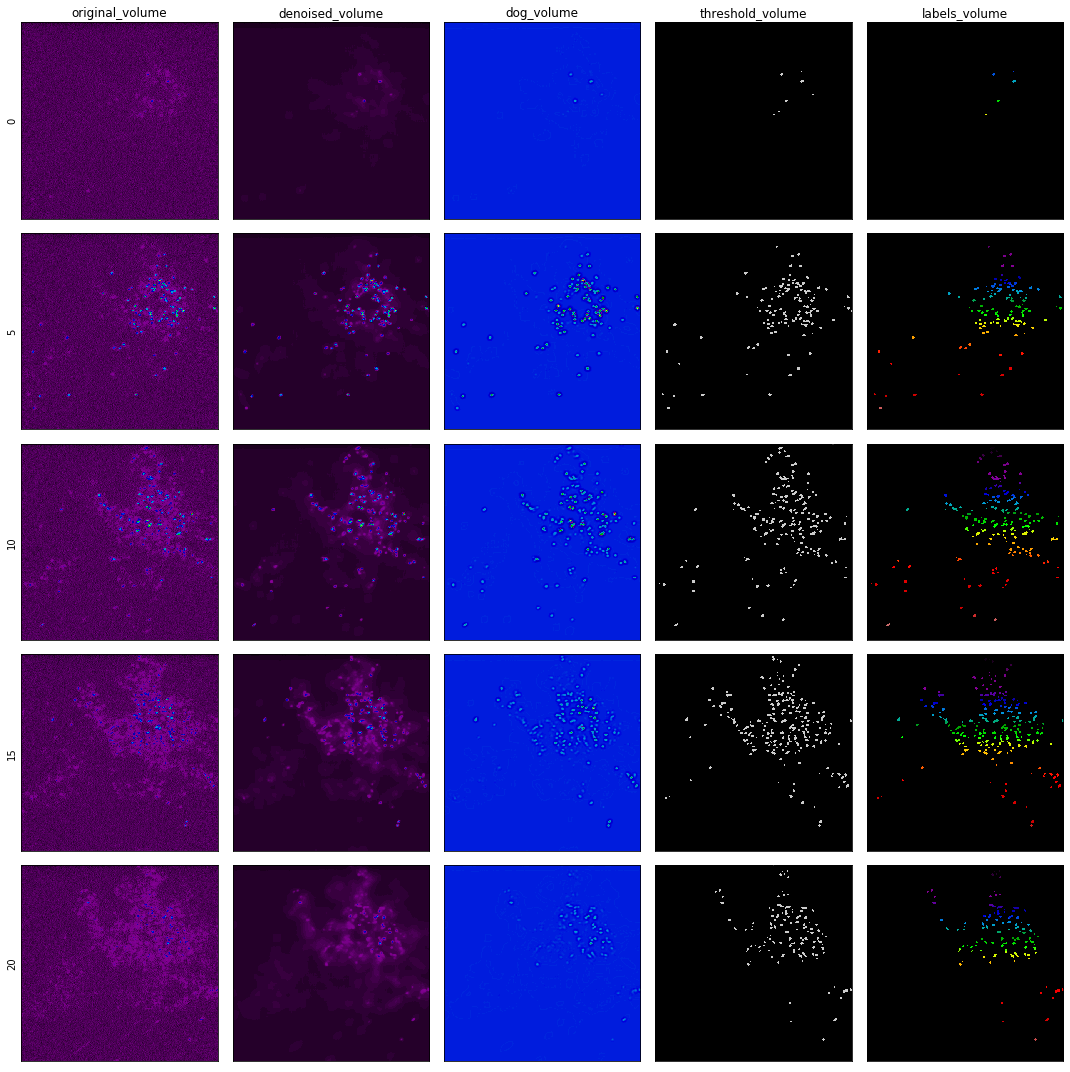

In [18]:
z_levels = [0, 5, 10, 15, 20]
figsize = (15,15)


cols = len(insp_steps)
rows = len(z_levels)

fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
for r, z in enumerate(z_levels):
    for c, stp in enumerate(insp_steps):
        axs[r, c].imshow(insp_steps[stp]['data'][...,z],
                         vmin=insp_steps[stp]['data'].min(),
                         vmax=insp_steps[stp]['data'].max(),
                        cmap='nipy_spectral') 
        
        axs[r, c].get_xaxis().set_ticks([])
        axs[r, c].get_yaxis().set_ticks([])
        
        if r == 0:
            axs[r, c].set_title(insp_steps[stp]['name'])
        if c == 0:
            axs[r, c].set_ylabel(z)
plt.tight_layout()

In [19]:
z_level = 5
fl.imshow((insp_steps[0]['data'][...,z_level])

SyntaxError: unexpected EOF while parsing (<ipython-input-19-fb10052e81af>, line 2)

## Inspect object positions - plot object positions at every 20th frame (approximately every min if frame rate 0.32). Chose which property to show in color (eg Calcium mean intensity)

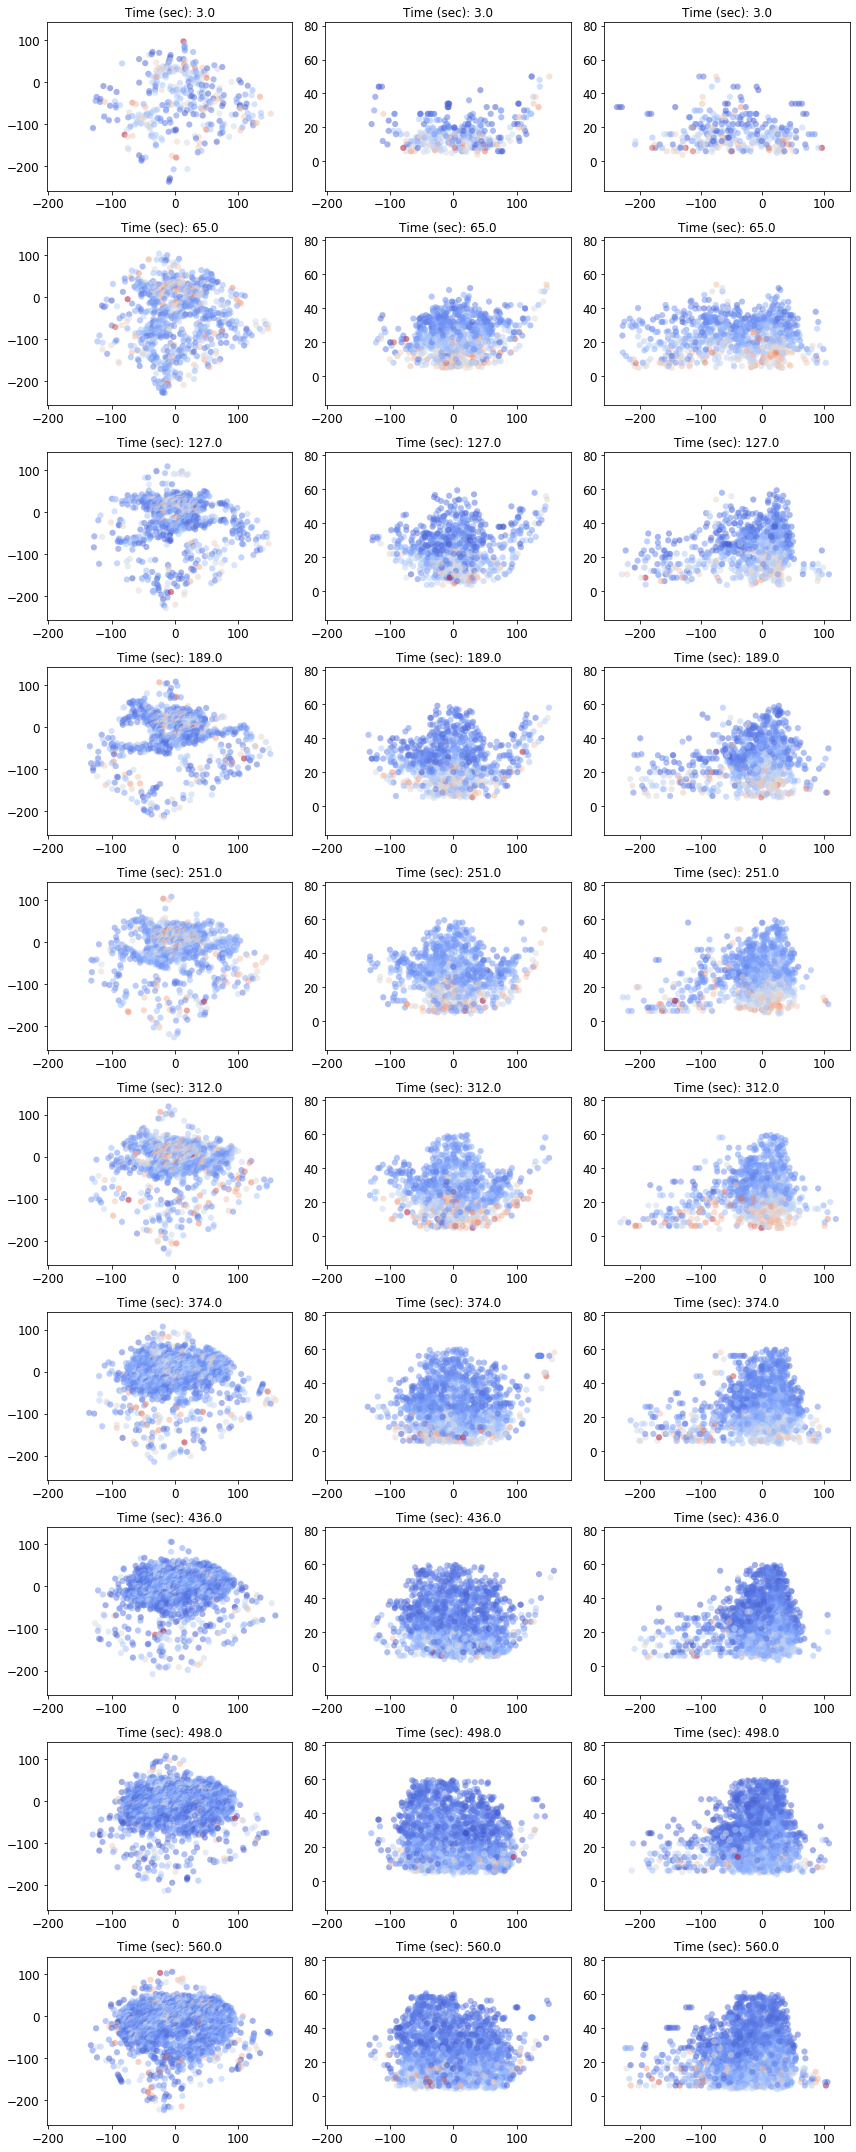

In [20]:

plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'jet_r'

#Gor lista av dimensioner 
lims=['xs', 'ys', 'zs']
limsv={}

#Anger gransvarden for de olika dimensionerna genom att kolla minsta och storsta varde och plussa pa 40
border=1.5
for l in lims:
    limsv[l]=df_obj[l].min()-20, df_obj[l].max()+20
    
col='path'
row='c'
hue='c'
x='frame'
y='z'
unit='c'

#Tar ut var 20:e frame fran frame 2 och framat
frames=pd.unique(df_obj.frame)[::20]+1
ncols=3
nrows=len(frames)

#Gor en lagom stor figur
plt.figure(figsize=(ncols*4,nrows*3))

#Valjer dimensioner att plotta 
cols=[('xs', 'ys'), ('xs', 'zs'), ('ys', 'zs')]

### name väljer variabel att färgsätta plottarna med
#name='cld'#name='stab'#name='c'#name='depth' #colorv=[1,2,4,8] #name='c2_max'
name='int_mean'

#vmin=0 #vmax=30#vmin=0
#vmax=10 #vmax=400

for r, f in enumerate(frames):
    sel_f=df_obj[df_obj.frame==f]
    
    for c, xy in enumerate(cols):
        ax=plt.subplot2grid((nrows, ncols), (r, c))
        #plt.setp()
        ax.scatter(sel_f[xy[0]], sel_f[xy[1]], alpha=0.5, c=sel_f[name], linewidth=0.1 )#, vmin=vmin, vmax=vmax,)
        ax.set_title('Time (sec): '+ str(np.round(sel_f.time.mean())),fontsize=12)
        ax.set_ylim(limsv[xy[1]])
        ax.set_xlim(limsv[xy[0]])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(labelsize=12)
        #ax.ticklabel_format()
        #ax.set_axis_bgcolor('black')
plt.tight_layout()


#fname='e__' + name + '.png'

#plt.savefig(fname, bbox_inches='tight', dpi=300)